# Data Preprocessing of the Kaggle Titanic Dataset

## Import all Libraries

In [1]:
# pandas: handle the datasets in the pandas dataframe for data processing and analysis
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: apply high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
print("sklearn version: {}". format(sklearn.__version__))

# matplotlib: standard library to create visualizations
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

# seaborn: advanced visualization library to create more advanced charts
import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

# turn out warnings for better reading in the Jupyter notebbok
pd.options.mode.chained_assignment = None  # default='warn'

pandas version: 1.4.2
numpy version: 1.21.5
sklearn version: 1.0.2
matplotlib version: 3.5.1
seaborn version: 0.11.2


## Load the processed Datasets
Load the saved processed training and test dataset pkl file. Make sure that you maybe have to change the folder path.

In [2]:
df_train = pd.read_pickle('../02_DataAnalysis/df_train.pkl')
df_test = pd.read_pickle('../02_DataAnalysis/df_test.pkl')

In [3]:
def pivot_survival_rate(df_train, target_column):
    # create a pivot table with the trget_column as index and "Survived" as columns
    # count the number of entries of "PassengerId" for each combination of trget_column and "Survived" and fill all empty cells with 0
    df_pivot = pd.pivot_table(
        df_train[['PassengerId', target_column, 'Survived']],
        index=[target_column],
        columns=["Survived"],
        aggfunc='count',
        fill_value=0)\
        .reset_index()

    # rename the columns to avoid numbers as column name
    df_pivot.columns = [target_column, 'not_survived', 'survived']

    # create a new column with the total number of survived and not survived passengers
    df_pivot['passengers'] = df_pivot['not_survived']+df_pivot['survived']

    # create a new column with the proportion of survivors to total passengers
    df_pivot['survival_rate'] = df_pivot['survived']/df_pivot['passengers']*100

    print(df_pivot.to_markdown())
    return df_pivot

## Feature Engineering (1/2)
The objective of feature engineering is to prepare the input datasets that the machine learning algorithms can work properly with the input data and also improve its performance regarding runtime or/and accuracy. **All new features must be computed for the training and test dataset**.

### New features: Family and Family_Grouped
Create two new features "Family" and "Family_Grouped" that defines the family situation of the passenger based on number of siblings / spouses ("SibSp") and parents / children ("Parch")

- "Family_Grouped" = 1: the passenger is alone
- "Family_Grouped" = 2...4: the passenger is part of a small family
- "Family_Grouped" = 5...6: the passenger is part of a medium family
- "Family_Grouped" = 7...11: the passenger is part of a large family

In [4]:
def get_family(df):
    df['Family'] = df["Parch"] + df["SibSp"] + 1
    
    family_map = {
        1: 'Alone',
        2: 'Small',
        3: 'Small',
        4: 'Small',
        5: 'Medium',
        6: 'Medium',
        7: 'Large',
        8: 'Large',
        9: 'Large',
        10: 'Large',
        11: 'Large'}
    df['Family_Grouped'] = df['Family'].map(family_map)
    
    return df

df_train = get_family(df_train)
df_test = get_family(df_test)

After creating the new "Family" feature, we want to know if there was a higher survival rate for families. We use the same function, that we created in the data analysis notebook.

In [5]:
_ = pivot_survival_rate(df_train, "Family_Grouped")

|    | Family_Grouped   |   not_survived |   survived |   passengers |   survival_rate |
|---:|:-----------------|---------------:|-----------:|-------------:|----------------:|
|  0 | Alone            |            374 |        163 |          537 |         30.3538 |
|  1 | Large            |             21 |          4 |           25 |         16      |
|  2 | Medium           |             31 |          6 |           37 |         16.2162 |
|  3 | Small            |            123 |        169 |          292 |         57.8767 |


#### Result
- From the table we see that the highest survival rate (57%) had passengers in small families between 2 and 4 passengers.
- Large and medium sized families had the lowest survival rate (16%).
- Interesting  is that passengers traveling alone were almost twice as likely to survive with 30%.

### New features from Name

- **First**: first name of the passenger
- **Last**: last name of the passenger
- **Title**: title of the passenger

From the family name, we can get additional information that we want to use to group family members. The assumption is that either all family members survived or died. We test this hypothesis by extracting the first and last name as well as the title from each name and calculate the survival rate for each family, defined by the same last name.

In [6]:
# combine the training and test dataset
df_train["dataset"] = "train"
df_test["dataset"] = "test"
df_merge = pd.concat([df_train, df_test])

In [7]:
df_merge[["Name"]].values[:10]

array([['Braund, Mr. Owen Harris'],
       ['Cumings, Mrs. John Bradley (Florence Briggs Thayer)'],
       ['Heikkinen, Miss. Laina'],
       ['Futrelle, Mrs. Jacques Heath (Lily May Peel)'],
       ['Allen, Mr. William Henry'],
       ['Moran, Mr. James'],
       ['McCarthy, Mr. Timothy J'],
       ['Palsson, Master. Gosta Leonard'],
       ['Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'],
       ['Nasser, Mrs. Nicholas (Adele Achem)']], dtype=object)

From the first lines, we see that the name feature has a defined structure that we can use to extract the attributes of the name.

In [8]:
def get_name_information(df):
    """
    extract the title, first name and last name from the name feature
    """
    df[['Last','First']] = df['Name'].str.split(",", n=1, expand=True)
    df[['Title','First']] = df['First'].str.split(".", n=1, expand=True)

    # remove the whitespace from the title
    df['Title'] = df['Title'].str.replace(' ', '')

    return df

In [9]:
# use the merged dataset to view if the training and test dataset contain family names
df_merge = get_name_information(df_merge)

last_pivot = pd.pivot_table(
    df_merge,
    values='Name',
    index='Last',
    columns='dataset',
    aggfunc='count'
    )\
    .sort_values(['train'], ascending=False)

last_pivot

dataset,test,train
Last,,
Andersson,2.0,9.0
Sage,4.0,7.0
Skoog,NaN,6.0
Carter,NaN,6.0
Goodwin,2.0,6.0
...,...,...
Wilson,1.0,NaN
Wirz,1.0,NaN
Wittevrongel,1.0,NaN


From the pivot table we see that there are families where we have passengers in the training and test dataset, but also families that are only in the training or only in the test dataset. Only if **family members are in the training and test dataset, the machine learning algorithm is able to get valuable information**.

In [10]:
print("Number of families that are only in the training data: " + str(len(last_pivot[last_pivot.test.isnull()])))
print("Number of families that are only in the test data: " + str(len(last_pivot[last_pivot.train.isnull()])))
print("Number of families that are in the training and test data: " + str(len(last_pivot[last_pivot.notnull().all(axis=1)])))

Number of families that are only in the training data: 523
Number of families that are only in the test data: 208
Number of families that are in the training and test data: 144


Take a closer look into the two largest families

In [11]:
df_merge[df_merge['Last'] == 'Andersson']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_category,Family,Family_Grouped,dataset,Last,First,Title
13,14,0.0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,adult,7,Large,train,Andersson,Anders Johan,Mr
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,adult,7,Large,train,Andersson,Erna Alexandra,Miss
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,children,7,Large,train,Andersson,Ellis Anna Maria,Miss
146,147,1.0,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,adult,1,Alone,train,Andersson,"August Edvard (""Wennerstrom"")",Mr
541,542,0.0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,children,7,Large,train,Andersson,Ingeborg Constanzia,Miss
542,543,0.0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,children,7,Large,train,Andersson,Sigrid Elisabeth,Miss
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,adult,7,Large,train,Andersson,Anders Johan (Alfrida Konstantia Brogren),Mrs
813,814,0.0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,children,7,Large,train,Andersson,Ebba Iris Alfrida,Miss
850,851,0.0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,children,7,Large,train,Andersson,Sigvard Harald Elias,Master
214,1106,NaN,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S,adult,7,Large,test,Andersson,Ida Augusta Margareta,Miss


The familiy Andersson has 
- 9 passengers in the training and 2 passengers in the test dataset
- 2 of the 9 passengers of the training dataset survived

-> If the two passengers of the test dataset survived is hard to predict based on the family name.

In [12]:
df_merge[df_merge['Last'] == 'Sage']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_category,Family,Family_Grouped,dataset,Last,First,Title
159,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,Thomas Henry,Master
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,Constance Gladys,Miss
201,202,0.0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,Frederick,Mr
324,325,0.0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,George John Jr,Mr
792,793,0.0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,Stella Anna,Miss
846,847,0.0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,Douglas Bullen,Mr
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,train,Sage,"Dorothy Edith ""Dolly""",Miss
188,1080,NaN,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,no age,11,Large,test,Sage,Ada,Miss
342,1234,NaN,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S,no age,11,Large,test,Sage,John George,Mr
360,1252,NaN,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,adult,11,Large,test,Sage,William Henry,Master


The familiy Sage has 
- 7 passengers in the training and 4 passengers in the test dataset
- all passengers of the training dataset died

-> Based on the family name, the machine learning algorithm would predict that also all 4 family members of the test dataset did not survive the Titanic.

In [13]:
# apply the name function to the training and test dataset
df_train = get_name_information(df_train)
df_test = get_name_information(df_test)

In [14]:
# plot the survival rate for each family
df_LastName = pivot_survival_rate(df_train, 'Last')

|     | Last                   |   not_survived |   survived |   passengers |   survival_rate |
|----:|:-----------------------|---------------:|-----------:|-------------:|----------------:|
|   0 | Abbing                 |              1 |          0 |            1 |          0      |
|   1 | Abbott                 |              1 |          1 |            2 |         50      |
|   2 | Abelson                |              1 |          1 |            2 |         50      |
|   3 | Adahl                  |              1 |          0 |            1 |          0      |
|   4 | Adams                  |              1 |          0 |            1 |          0      |
|   5 | Ahlin                  |              1 |          0 |            1 |          0      |
|   6 | Aks                    |              0 |          1 |            1 |        100      |
|   7 | Albimona               |              0 |          1 |            1 |        100      |
|   8 | Alexander              |        

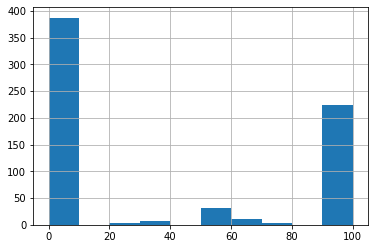

In [15]:
# create a histogram to visualize the survival rate
df_LastName['survival_rate'].hist()
plt.show()

#### Result
From the histogram we see that in most cases either all family members died (survival rate = 0) or survived (survival rate = 100). Therefore the new feature "LastName" could be an important feature to predict the survival rate if the training and test dataset both contain passengers of the same last name.

-> Prove the assumption in a later stage of the project with feature importance.

### New feature: Title
Create a new feature "Title" based on the feature "Name" because the feature "Name" is too unique that the algorithm could find a relation between the name and the survival rate. But because the name contains a title, we could save the title and maybe find a correlation between the title and the survival rate.

In [16]:
df_train['Title'].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
theCountess      1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: Title, dtype: int64

If we count all unique titles, we see that there are a lot of unique titles, that we want to group as rare title.

In [17]:
def rename_title(df):
    df.loc[df["Title"] == "Dr", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Rev", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Col", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Ms", "Title"] = 'Miss'
    df.loc[df["Title"] == "Major", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Mlle", "Title"] = 'Miss'
    df.loc[df["Title"] == "Mme", "Title"] = 'Mrs'
    df.loc[df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Lady", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "theCountess", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Capt", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Don", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Sir", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Dona", "Title"] = 'Rare Title'
    return df

# apply the title rename function to the training and test set
df_train = rename_title(df_train)
df_test = rename_title(df_test)

In [18]:
_ = pivot_survival_rate(df_train, "Title")

|    | Title      |   not_survived |   survived |   passengers |   survival_rate |
|---:|:-----------|---------------:|-----------:|-------------:|----------------:|
|  0 | Master     |             17 |         23 |           40 |         57.5    |
|  1 | Miss       |             55 |        130 |          185 |         70.2703 |
|  2 | Mr         |            436 |         81 |          517 |         15.6673 |
|  3 | Mrs        |             26 |        100 |          126 |         79.3651 |
|  4 | Rare Title |             15 |          8 |           23 |         34.7826 |


#### Result
The survival rate for passengers with the title Mrs (79%) and Miss (70%) are the highest. If we compare the male title Master (59.5%) and Mr (15.7%), we see that passengers with the title Master have a 43.8% higher survival rate.

### New features from Ticket
- **Prefix**: non numerical prefix of a ticket
- **TNlen**: length of numeric ticket number
- **LeadingDigit**: first digit of numeric ticket number
- **TGroup**: numeric ticket number without the last digit

In [19]:
df_train[['Ticket']].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


If we take a look at the "Ticket" feature, we can see that there is a **schema in that ticket feature**. The ticket contains consists of a first non numeric part with or without special character and a second numeric part or only the numeric part. With this schema in mind, we can create a function to extract different features out of the ticket.

In [20]:
def get_prefix(ticket):
    """
    check if the first part of the ticket (separated by a space) are letters
    return only the letter or the information that the first part does not contain only letter
    """
    lead = ticket.split(' ')[0][0]
    if lead.isalpha():
        return ticket.split(' ')[0]
    else:
        return 'NoPrefix'

def ticket_features(df):
    """
    Prefix: non numerical prefix of a ticket
    TNlen: length of numeric ticket number
    LeadingDigit: first digit of numeric ticket number
    TGroup: numeric ticket number without the last digit
    """
    df['Ticket'] = df['Ticket'].replace('LINE','LINE 0')
    df['Ticket'] = df['Ticket'].apply(lambda x: x.replace('.','').replace('/','').lower())
    df['Prefix'] = df['Ticket'].apply(lambda x: get_prefix(x))
    df['TNumeric'] = df['Ticket'].apply(lambda x: int(x.split(' ')[-1]))
    df['TNlen'] = df['TNumeric'].apply(lambda x : len(str(x)))
    df['LeadingDigit'] = df['TNumeric'].apply(lambda x : int(str(x)[0]))
    df['TGroup'] = df['TNumeric'].apply(lambda x: str(x//10))

    df = df.drop(columns=['Ticket','TNumeric'])

    return df

df_train = ticket_features(df_train)
df_test = ticket_features(df_test)

In [21]:
df_train[['Prefix', 'TNlen', 'LeadingDigit', 'TGroup']].head()

,Prefix,TNlen,LeadingDigit,TGroup
0,a5,5,2,2117
1,pc,5,1,1759
2,stono2,7,3,310128
3,NoPrefix,6,1,11380
4,NoPrefix,6,3,37345


#### Result LeadingDigit
- the lower the leading digit, the higher is the survival rate
- but for 0, the survival rate is lower (maybe these 4 passengers are some special passengers)

In [22]:
# show the survival rate for each LeadingDigit
_ = pivot_survival_rate(df_train, "LeadingDigit")

|    |   LeadingDigit |   not_survived |   survived |   passengers |   survival_rate |
|---:|---------------:|---------------:|-----------:|-------------:|----------------:|
|  0 |              0 |              3 |          1 |            4 |        25       |
|  1 |              1 |             91 |        140 |          231 |        60.6061  |
|  2 |              2 |            136 |         94 |          230 |        40.8696  |
|  3 |              3 |            272 |         95 |          367 |        25.8856  |
|  4 |              4 |             13 |          2 |           15 |        13.3333  |
|  5 |              5 |              7 |          2 |            9 |        22.2222  |
|  6 |              6 |             13 |          1 |           14 |         7.14286 |
|  7 |              7 |             11 |          4 |           15 |        26.6667  |
|  8 |              8 |              3 |          0 |            3 |         0       |
|  9 |              9 |              0 |   

#### Result TNlen
- there are clear differences in the survival rate in the TNlen feature
- passengers with a numeric ticket length of 5 have the highest survival rate of 65.5%
- the two other TNlen classes with >100 passengers have only a survival rate of around 32%

In [23]:
# show the survival rate for each TNlen
_ = pivot_survival_rate(df_train, "TNlen")

|    |   TNlen |   not_survived |   survived |   passengers |   survival_rate |
|---:|--------:|---------------:|-----------:|-------------:|----------------:|
|  0 |       1 |              5 |          1 |            6 |         16.6667 |
|  1 |       3 |              4 |          3 |            7 |         42.8571 |
|  2 |       4 |            113 |         52 |          165 |         31.5152 |
|  3 |       5 |            107 |        139 |          246 |         56.5041 |
|  4 |       6 |            288 |        135 |          423 |         31.9149 |
|  5 |       7 |             32 |         12 |           44 |         27.2727 |


#### Result Prefix
- 661 passengers have no prefix in their tickets
- for some classes with higher numer of passengers have eigher a higher or lower survival rate, compared to the mean survival rate of 38%
 - fcc: 80%
 - pc: 65%
 - sotonoq: 13%
 - wc: 10%
 - a5: 9.5%
 - a4: 0%

In [24]:
# show the survival rate for each Prefix
_ = pivot_survival_rate(df_train, "Prefix")

|    | Prefix   |   not_survived |   survived |   passengers |   survival_rate |
|---:|:---------|---------------:|-----------:|-------------:|----------------:|
|  0 | NoPrefix |            407 |        254 |          661 |        38.4266  |
|  1 | a4       |              7 |          0 |            7 |         0       |
|  2 | a5       |             19 |          2 |           21 |         9.52381 |
|  3 | as       |              1 |          0 |            1 |         0       |
|  4 | c        |              3 |          2 |            5 |        40       |
|  5 | ca       |             27 |         14 |           41 |        34.1463  |
|  6 | casoton  |              1 |          0 |            1 |         0       |
|  7 | fa       |              1 |          0 |            1 |         0       |
|  8 | fc       |              1 |          0 |            1 |         0       |
|  9 | fcc      |              1 |          4 |            5 |        80       |
| 10 | line     |           

#### Result TGroup
There are too many unique values for TGroup to visualize in a table. Therefore we filter the training data to the samples with a TGroup, that contains more or equal 10 passengers and calculate the survival rate for this selection of TGroup.

From the catplot you see that the survival rate differs much between the categories of TGroup, but all TGroup have also a high width of the confidence interval.

In [25]:
# there are too many unique values for TGroup
df_train.TGroup.nunique()

338

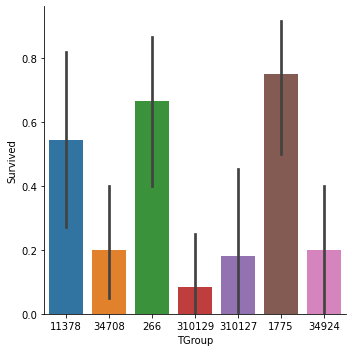

In [26]:
# group the training data by TGroup to get the number of passengers per TGroup
df_tgroup = df_train[['TGroup', 'PassengerId']].groupby(['TGroup']).nunique().sort_values(by='PassengerId', ascending=False)
# filter TGroup that contains more or equal 10 passengers
df_tgroup = df_tgroup[df_tgroup.PassengerId >= 10]

# filter the whole training data to the samples that are in the selection of TGroup
df_tgroup = df_train[df_train['TGroup'].isin(df_tgroup.index)]

# create a catplot for the survival rate of each filtered TGroup
sns.catplot(x='TGroup', y="Survived", data=df_tgroup, kind="bar")
plt.show()

## Fix or Remove Outliers
 **Numeric features that have only few unique values like, "Parch", "Pclass" and "SibSp" can have outliers.** The risk is too high to delete one unique value that has only a few entries, because if the test set contains this value, the algorithm has no chance to consider this value. Therefore, we only look for outliers in "Age" and "Fare".

 Moreover we will create two new features by clipping the Age and Fare features. That will also handle potential outliers.

### Find outliers using Box Plots
Box plots are a graphical depiction of numerical data through their quantiles and therefore a very simple but effective way to visualize outliers.

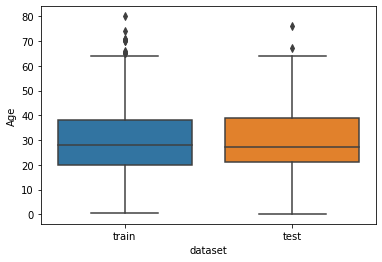

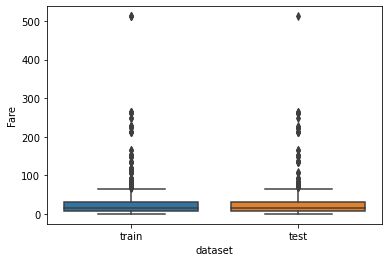

In [27]:
# define a list with numeric features of which we want to look at the boxplot
num_features = ["Age", "Fare"]

# combine the training and test dataset
df_merge = pd.concat([df_train, df_test])

# create a boxplot of each selected feature seperated by the training and test dataset
for feature in num_features:
    plt.figure() # create a new figure for each plot
    sns.boxplot(data=df_merge, y=feature, x="dataset")
    plt.show()

From the two boxplots we see that the age of some passengers could be seen as outliers, but are close enough to the upper whiskers to keep all values in "Age". For the feature **"Fare" all values higher than 300 could be classified as outliers but data points are in the training and test dataset**. Samples in the test dataset can not be removed because otherwise the submission has not the same number of samples. Therefore we do not remove samples as outliers.

### Find outliers using Inerquatile Range Method
Using the Inerquatile Range Method, we create And create one feature per analyzed outlier feature that indicate that the sample has an outlier. We use this approach to find outliers, because we get more outliers in the feature. When we only flag the samples that are conspicous in the box-plot, the new feature has a low variance and the possibility is high that this new feature will be deteted in the feature selection section.

<input type="checkbox"> **One impoartant step will be to flag the missing values for Age after we either remove the missing samples or using an imputation method**

In [28]:
def find_outlier_Interquartile_Range_Method(df_train, feature):
    print(feature)
    v_fraud = df_train[feature].dropna().values
    q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
    print('Quartile25: {} | Quartile75: {}'.format(q25, q75))
    v14_iqr = q75-q25
    
    print('iqr: {}'.format(v14_iqr))
    v_cut_off = v14_iqr*1.5
    v_lower, v_upper = q25-v_cut_off, q75+v_cut_off
    print('CtOff: {}'.format(v_cut_off))
    print('Lower: {}'.format(v_lower))
    print('Upper: {}'.format(v_upper))
    
    outliers = [x for x in v_fraud if x<v_lower or x>v_upper]
    print('Number of Outliers: {} ({}%)'.format(len(outliers), round(len(outliers)/len(df_train)*100,0)))
    print("\n")

    return v_lower, v_upper

In [29]:
dict_interquartile_ranges = {}

for feature in num_features:
    # get the lower and upper bounds of the interquartile range method
    v_lower, v_upper = find_outlier_Interquartile_Range_Method(df_train, feature)
    dict_interquartile_ranges[feature] = (v_lower, v_upper)

    # create a new feature in the training dataset and set the feature to 1 if the lower and upper bounds are cut
    df_train[feature + "_outlier"] = 'no_outlier'
    df_train[feature + "_outlier"].iloc[df_train[feature].isna()] = 'missing_value'
    df_train[feature + "_outlier"].iloc[(df_train[feature]>v_upper) | (df_train[feature]<v_lower)] = 'outlier'

    # create a new feature in the test dataset and set the feature to 1 if the lower and upper bounds are cut
    df_test[feature + "_outlier"] = 'no_outlier'
    df_train[feature + "_outlier"].iloc[df_train[feature].isna()] = 'missing_value'
    df_test[feature + "_outlier"].iloc[(df_test[feature]>v_upper) | (df_test[feature]<v_lower)] = 'outlier'

Age
Quartile25: 20.125 | Quartile75: 38.0
iqr: 17.875
CtOff: 26.8125
Lower: -6.6875
Upper: 64.8125
Number of Outliers: 11 (1.0%)


Fare
Quartile25: 7.9104 | Quartile75: 31.0
iqr: 23.0896
CtOff: 34.6344
Lower: -26.724
Upper: 65.6344
Number of Outliers: 116 (13.0%)




## Fix or Remove Missing Values
From the statistic report we already saw that there are missing values in the training and test dataset. With the following function you get a better overview of the missing values.

In [30]:
def find_missing_values(df):
    """
    find missing values in the dataframe
    return the features with missing values, the total number of missing values and the percentage of missing values
    """
    total = df.isnull().sum().sort_values(ascending=False) # compute the total number of missing values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) # compute the percentage of missing values
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # add all information to one dataframe
    missing_data = missing_data[missing_data['Total']>0] # filter the dataframe to only the features with missing values
    return missing_data

In [31]:
find_missing_values(df_train)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [32]:
find_missing_values(df_test)

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


### Results
- There are 77% and 78% missing values in "Cabine" **-> delete feature**
- There are 2 missing values in "Embarked" only in the training data **-> input by comparison**
- There is 1 missing values in "Fare" only in the test data  **-> input by comparison**
- There are 20% missing values in "Age" **-> input by algorithm**

### Missing values of "Cabin"
For the column "Cabin" there are more than 77% and 78% of missing values, too much to find a system to fill the missing values. Therefore we delete the whole feature from the training and in the test dataset because the algorithm needs the same features for the learning model and the prediction.

In [33]:
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

### Missing values of "Embarked"
There are two missing values for "Embarked" in the training dataset. We want to take a closer look of these two samples.

In [34]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,...,dataset,Last,First,Title,Prefix,TNlen,LeadingDigit,TGroup,Age_outlier,Fare_outlier
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN,...,train,Icard,Amelie,Miss,NoPrefix,6,1,11357,no_outlier,outlier
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN,...,train,Stone,George Nelson (Martha Evelyn),Mrs,NoPrefix,6,1,11357,no_outlier,outlier


From the table we see that both passengers have the "Pclass" of 1 and a "Fare" of 80. We want to find out what is the port of embarkation with the highest likelihood for passengers with a "Pclass" of 1 and a "Fare" of 80. Therefore we create a boxplot with "Embarked" as x-axis, "Fare" as y-axis and separated by the "Pclass".

If we limit the Fare to < 200, we have a little error in the boxplot. But this error does not change the result and improves the readability.

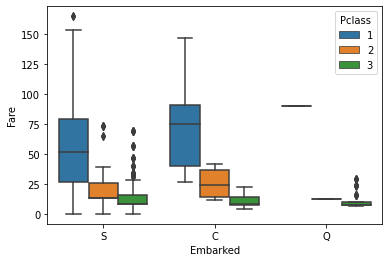

In [35]:
# limit the "Fare" to values lower than 200 to make the chart more readable
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=df_train[df_train['Fare']<200])
plt.show()

From the boxplot we see that passengers that embarked from Cherbourg had a median fare of 80 of the 1 passenger class. Also we already know that passengers of Cherbourg (C) have the highest survival rate with 55% and both passengers survived. Therefore we will fill the two missing values of "Embarked" with Cherbourg.

In [36]:
df_train["Embarked"] = df_train["Embarked"].fillna("C")

### Missing values of "Fare"
There is one missing values of "Fare" in the test dataset. We will use the same process like we did with the missing values of "Embarked". Fist we take a closer look at the passenger with the missing value of "Fare".

In [37]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_category,...,dataset,Last,First,Title,Prefix,TNlen,LeadingDigit,TGroup,Age_outlier,Fare_outlier
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S,senior,...,test,Storey,Thomas,Mr,NoPrefix,4,3,370,no_outlier,no_outlier


We see that the passenger had a "Pclass" of 3 and "Embarked" in Southampton. Therefore we fill the missing value of "Fare" with the median fare for all passengers that embarked in Southampton with the passenger class 3.

In [38]:
median_fare = df_test[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S')]['Fare'].median()
df_test["Fare"] = df_test["Fare"].fillna(median_fare)

### Fill missing values for "Age"
For the feature “Age” there are around 20% of missing values in the training and test dataset. The missing values of age are very hard to estimate or calculate by a mean or median. Therefore, we use a Random Forest Regressor to fill the missing values. The following points show the process:
1.	First, we combine the training and test set to be able to fill the missing values in both datasets. Afterwards we input the missing values, we split the datasets again into the training and test set.
2.	The second step is to split the combined dataset into a dataset where we know the age of the passengers (age_train) and in one dataset, where is "Age" column contains the missing values (age_test).
3.	Then we train the Random Forest Regressor with the training set and predict the "Age" of the test set.
4.	In the last step we replace the missing values of age with the predicted output of the test set.

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# predicting missing values in age using Random Forest
def fill_missing_age(df):
    # Feature set
    age_df = df[[
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family', 'Family_Grouped', 'Title',
        'Prefix', 'TGroup', 'Age_outlier', 'Fare_outlier']]
    # Split sets into train and test
    age_train = age_df.loc[(age_df.Age.notnull())]  # known Age values
    age_test = age_df.loc[(age_df.Age.isnull())]  # null Ages

    # All age values are stored in a target array
    age_train_y = age_train[['Age']]

    # All the other values are stored in the feature array
    age_train_x = age_train.drop('Age', axis=1)

    # Create a RandomForestRegressor object
    rtr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    
    categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Family', 'Family_Grouped', 'Title',
        'Prefix', 'TGroup', 'Age_outlier', 'Fare_outlier']
    numeric_features = ['Fare']
    
    col_transform = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                ('num', StandardScaler(), numeric_features)
            ]
        )
    
    # define pipeline
    pipeline = Pipeline(steps=[
        ('columnprep', col_transform),
        ('reducedim', TruncatedSVD(n_components=20)),
        ('regression', rtr)
    ])
    
    
    pipeline.fit(age_train_x, age_train_y.values.ravel())

    # Print the R2 score for the training set
    print("R2 score for training set: " + str(pipeline.score(age_train_x, age_train_y)))
    age_train_y_pred = pipeline.predict(age_train_x)

    # plot the actual and predicted values of the training set
    plt.scatter(age_train_y, age_train_y_pred)
    plt.plot([min(age_train_y_pred),max(age_train_y_pred)], [min(age_train_y_pred),max(age_train_y_pred)], c="red")
    plt.xlabel('Age training set')
    plt.ylabel('Age training set predicted')
    plt.show()

    # Use the fitted model to predict the missing values
    predictedAges = pipeline.predict(age_test.drop('Age', axis=1))

    # Assign those predictions to the full data set
    df.loc[(df.Age.isnull()), 'Age'] = predictedAges

    return df

R2 score for training set: 0.847409049851687


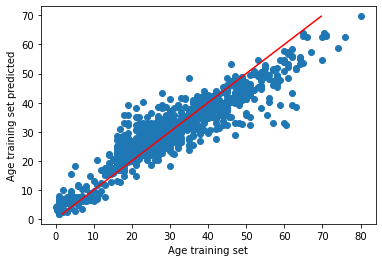

In [40]:
train_objs_num = len(df_train)

features_all = pd.concat([df_train, df_test], axis=0)
features_all = fill_missing_age(features_all)

df_train = features_all[:train_objs_num]
df_test = features_all[train_objs_num:]

The R2 score of the training data is 0.84 which is very good. The picture shows for the age trainings set the actual values and the predicted values. With a perfect solution of R2=1, all points would be on the red line.

After we filled the missing values of age, we have to recompute the age category from the data analysis part, because the feature "age_category" is currently "no age" for these samples and we have to mark again the outliers that could be created via the imputation of the missing values of age.

In [41]:
def age_category(row):
    """
    Function to transform the actual age in to an age category
    Thresholds are deduced from the distribution plot of age
    """
    if row < 12:
        return 'children'
    if (row >= 12) & (row < 60):
        return 'adult'
    if row >= 60:
        return 'senior'
    else:
        return 'no age'

# apply the function age_category to each row of the dataset
df_train['Age_category'] = df_train['Age'].apply(lambda row: age_category(row))
df_test['Age_category'] = df_test['Age'].apply(lambda row: age_category(row))

# show the suvival table with the previously created function
_ = pivot_survival_rate(df_train, "Age_category")

|    | Age_category   |   not_survived |   survived |   passengers |   survival_rate |
|---:|:---------------|---------------:|-----------:|-------------:|----------------:|
|  0 | adult          |            492 |        289 |          781 |         37.0038 |
|  1 | children       |             33 |         42 |           75 |         56      |
|  2 | senior         |             24 |         11 |           35 |         31.4286 |


There are some changes in the survival rate after we input the missing values of age:
- adult: from 39% to 37%
- children: from 57% to 55%
- senior: from 27% to 32%

In [42]:
df_train["Age_outlier"].value_counts()

no_outlier       703
missing_value    177
outlier           11
Name: Age_outlier, dtype: int64

In [43]:
df_train["Age_outlier"] = "no_outlier"
df_test["Age_outlier"] = "no_outlier"

df_train["Age_outlier"].iloc[(df_train[feature] > dict_interquartile_ranges["Age"][1]) | (df_train[feature] < dict_interquartile_ranges["Age"][0])] = "outlier"
df_test["Age_outlier"].iloc[(df_test[feature] > dict_interquartile_ranges["Age"][1]) | (df_test[feature] < dict_interquartile_ranges["Age"][0])] = "outlier"

In [44]:
df_train["Age_outlier"].value_counts()

no_outlier    773
outlier       118
Name: Age_outlier, dtype: int64

From the imputation of the Age feature, we can see that from 177 missing values, 107 (60%) are now categorized as missing values, and 70 (40%) are no outlier, when we do not change the calculated interquartiles.

In [45]:
df_train.to_pickle('df_train_prepared_unfinished.pkl')
df_test.to_pickle('df_test_prepared_unfinished.pkl')

## Feature Engineering (2/2)
Discretize Fare and Age after inputing the missing values, because otherwise the discretized age feature would also contain missing values, that prevents our algorithm from running.

Why discretize features?
- Helped to expose groups with higher survival rate.
- Summarizes outliers in the lowest or highest class.

### New features: Discretize Fare

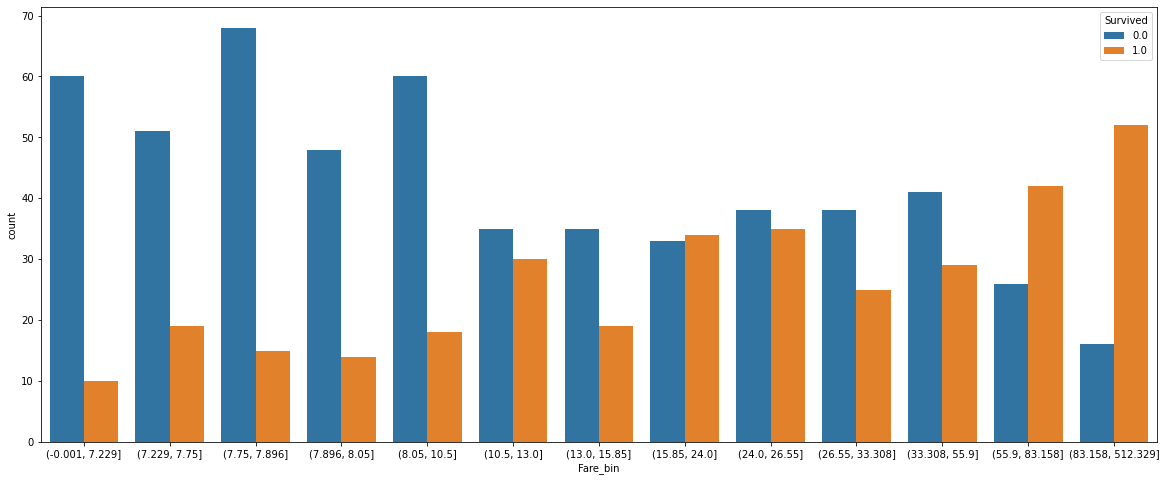

In [48]:
df_train['Fare_bin'] = pd.qcut(df_train['Fare'], 13)

fig, axs = plt.subplots(figsize=(20, 8))
sns.countplot(x='Fare_bin', hue='Survived', data=df_train)
plt.show()

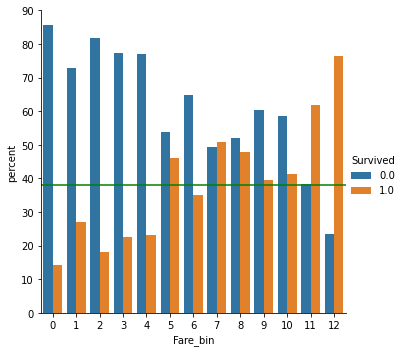

In [49]:
df_train['Fare_bin'] = pd.qcut(df_train['Fare'], 13, labels=False)
df_test['Fare_bin'] = pd.qcut(df_test['Fare'], 13, labels=False)

(df_train
.groupby("Fare_bin")["Survived"]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x="Fare_bin", y='percent',hue="Survived",kind='bar'))
plt.axhline(y=38, color='g', linestyle='-')
plt.show()

### New features: Discretize Age

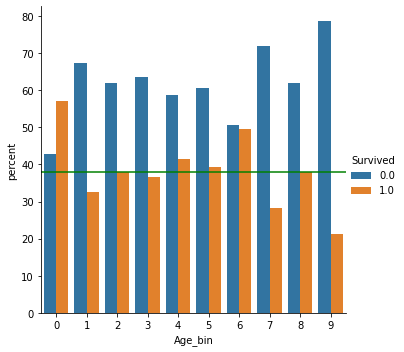

In [50]:
df_train['Age_bin'] = pd.qcut(df_train['Age'], 10, labels=False)
df_test['Age_bin'] = pd.qcut(df_test['Age'], 10, labels=False)

(df_train
.groupby("Age_bin")["Survived"]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x="Age_bin", y='percent',hue="Survived",kind='bar'))
plt.axhline(y=38, color='g', linestyle='-')
plt.show()

## Noise in Features (Data Scaling)
The next part of the data cleaning is to analyze if there is any noise in the features. There are multiple kinds of noise, but we will focus on the following two kinds:

- **Is there a noise between the training and test dataset** that would prevent the machine learning algorithm from learning because there are missing values for a feature either in the training or test dataset?
- **Is there any noise in one or more feature based on its distribution?** If there is any noise for example through outliers or rounding errors, we maybe must process the data to create a more normal distribution.

### Is there Noise between the Training and Test Dataset?
The easiest and fastest way to analyze the noise in a feature is to view the distribution of each numeric feature separated by the training and test dataset.

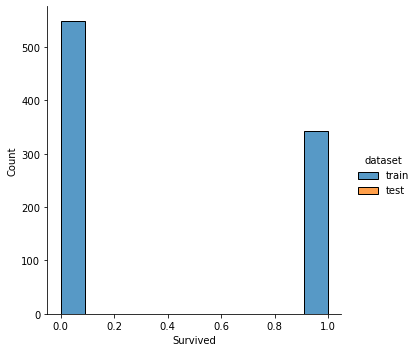

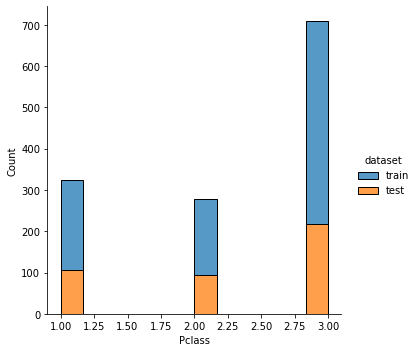

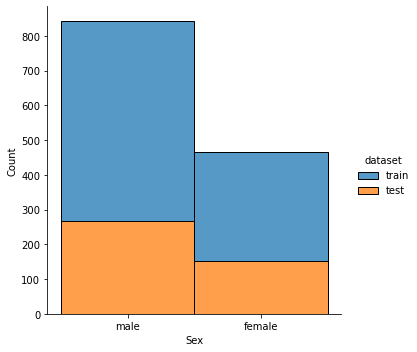

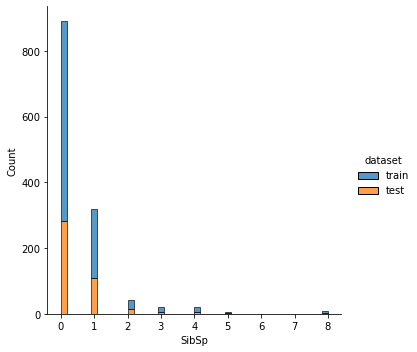

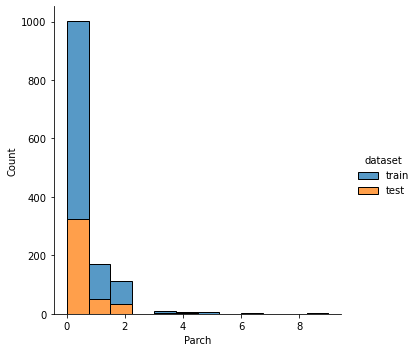

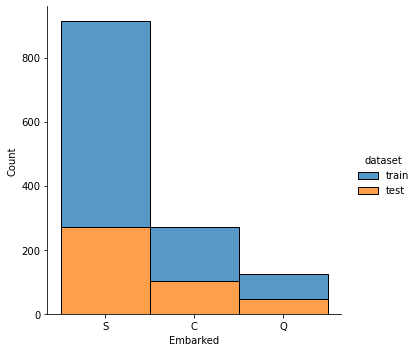

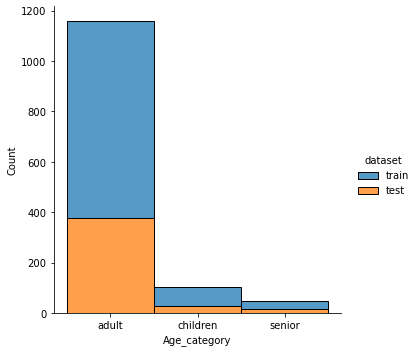

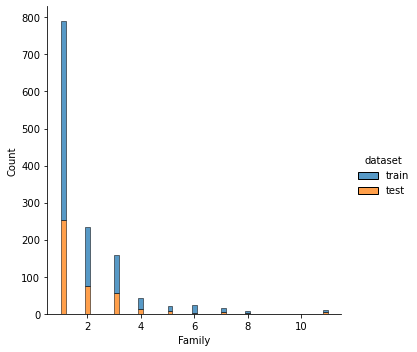

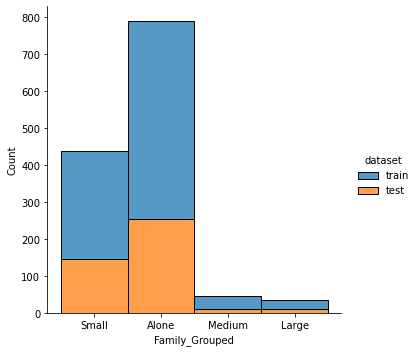

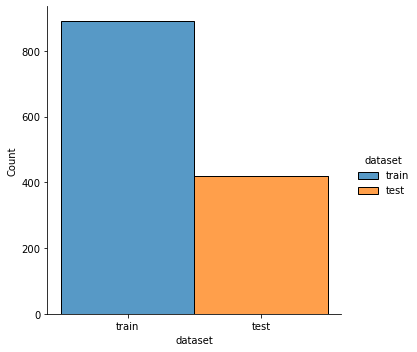

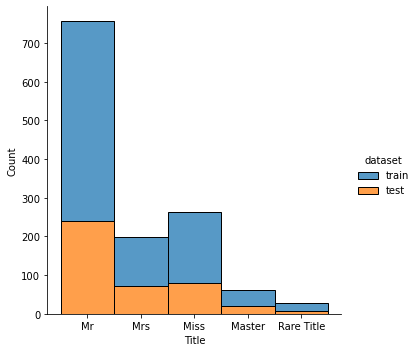

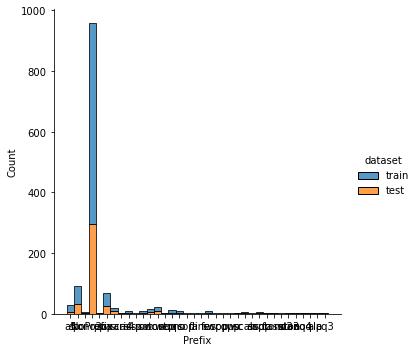

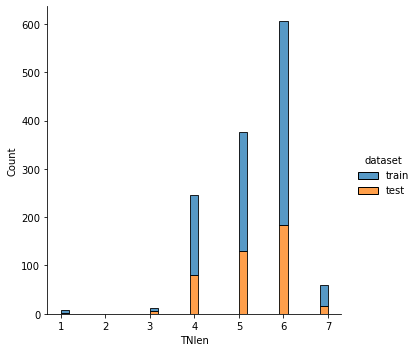

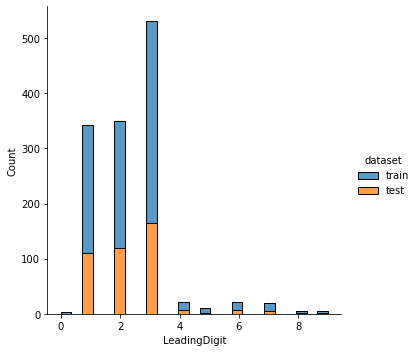

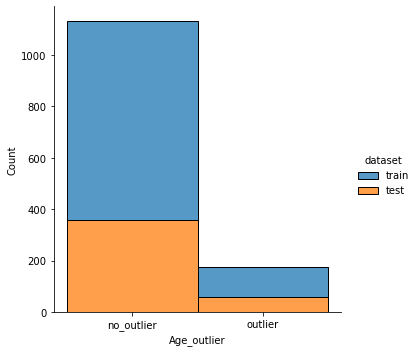

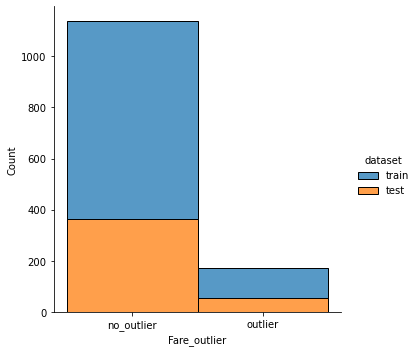

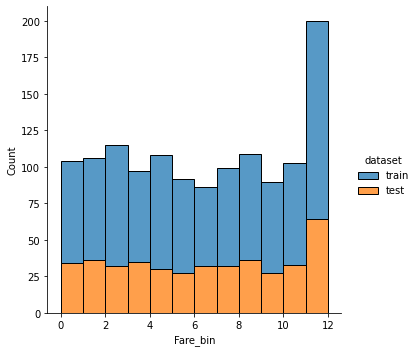

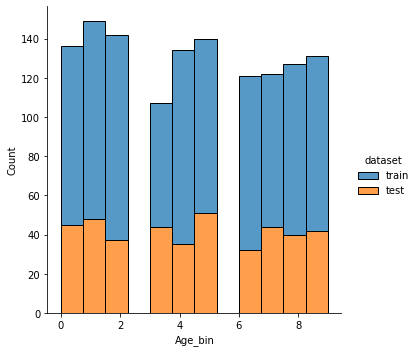

In [51]:
# combine the training and test dataset
df_merge = pd.concat([df_train, df_test], ignore_index=True)

# plot the distribution plot of each selected feature seperated by the training and test dataset
for feature in df_merge.columns:
    # plot only the distribution if there are less than 100 unique values for the feature
    # for example name has a lot of unique values that will be one-hot-encoded for the classifier
    if df_merge[feature].nunique() < 100:
        sns.displot(df_merge, x=feature, hue="dataset", multiple="stack")
        plt.show()

The result of the histograms is that the features are well distributed between the training and test dataset. There is no class that is only present in only the training or test dataset.

### Is there any Noise in one or more Feature based on its Distribution?
To analyze the dataset for general noise based on its distribution, we use the scipy stats library to compute the skewness of every feature:
- skewness = 0: normally distributed
- skewness > 0: more weight in the left tail of the distribution → square , cube root and logarithmic
- skewness < 0: more weight in the right tail of the distribution → possible transformations: square root, cube root, and log

We compute the skewness of the combined training and test data with the following function and only return features that have a strong skewness >1 or <-1.

In [52]:
from scipy.stats import skew
def compute_skewed_features(df):
    """
    compute the skewness of all numeric features and the total number of unique values
    return only the features that have a relevant skewness
    """
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = pd.DataFrame(index=numeric_feats, columns=['skewness', 'unique_values'])
    skewed_feats['skewness'] = df[numeric_feats].apply(lambda x: skew(x))
    skewed_feats['unique_values'] = df.nunique()
    skewed_feats = skewed_feats[(skewed_feats['skewness'] > 1) | (skewed_feats['skewness'] < -1)]

    return skewed_feats

# combine the training and test dataset
df_merge = pd.concat([df_train, df_test])
skewed_feats = compute_skewed_features(df_merge)

skewed_feats

,skewness,unique_values
SibSp,3.839814,7
Parch,3.664872,8
Fare,4.364205,281
Family,2.849808,9
LeadingDigit,1.725896,10


From the table, we see that there are
- 4 features ("SibSp", "Parch", "Family", "LeadingDigit") that are positive skewed but have few unique values because they are classes. **→ no transformation**
- 1 feature ("Fare") is positive skewed and has >=10 unique values. **→ apply the logarithmic transformation**

**Log transform Fare**

Apply the log transformation to "Fare" and "Prefix" of the training and test dataset and show the distribution chart after the log transformation.

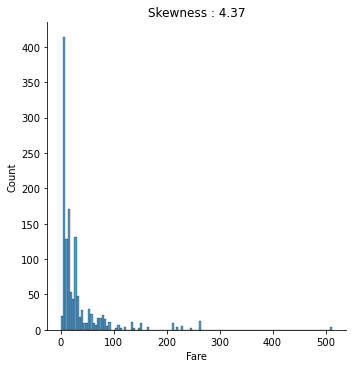

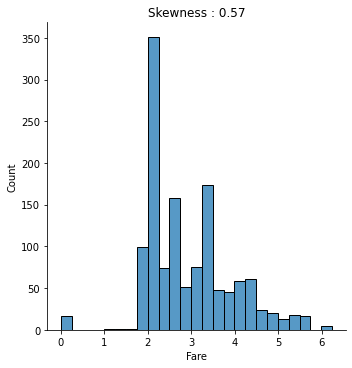

In [53]:
for feature in ['Fare']:
    
    # view the distribution of Fare after the log transformation with the skewness
    df_merge = pd.concat([df_train, df_test])
    g = sns.displot(df_merge[feature])
    plt.title("Skewness : %.2f"%(df_merge[feature].skew()))
    plt.show()
    
    df_train[feature] = df_train[feature].apply(np.log)
    df_test[feature] = df_test[feature].apply(np.log)

    # the not transformed data that contains 0
    # after the transformation we have -inf values that have to be replaced by 0
    df_train[feature][np.isneginf(df_train[feature])]=0
    df_test[feature][np.isneginf(df_test[feature])]=0

    # view the distribution of Fare after the log transformation with the skewness
    df_merge = pd.concat([df_train, df_test])
    g = sns.displot(df_merge[feature])
    plt.title("Skewness : %.2f"%(df_merge[feature].skew()))
    plt.show()

## Feature Selection (1/2)
It makes sense to logically think about every feature in the dataset, if this feature could have an influence on the survival rate of a passenger. If not, we can delete this feature from the training and test dataset. The following list shows you the features we delete from both datasets with the appropriate reason.
- "PassengerID" is only a continuous numeration of each row and only a technical feature of the datasets.
- "Name" and "First" have (nearly) only unique values. Therefore the chances to find an influence on the survival rate is close to zero. We created the additional features "Name".
- "dataset" was created during our analysis, when we combined the training and test dataset is has therefore be deleted.

In [54]:
df_train.drop(['PassengerId', 'Name', 'dataset', 'First'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'dataset', 'Survived', 'First'], axis=1, inplace=True)

## Transform Categoric Features to Numeric
Categorical features have to be transformed to numbers to be an input to an algorithm. Therefore we will decompose these features. We can also build custom transformations that are part of the optimization process of the machine learning process and very handy to quickly change decisions of the feature engineering. Also there are advantages to scale features with different transformations to improve the machine learning algorithm.

There are multiple options to transform categorical features into numeric:
- Labels
    - **Lable Encoder:** transform each category in a serial number. Disadvantage is that the machine learning algorithm will assume that two nearby values are more similar than two distant values, what is not the case.
    - **Label Binarizer:** Label Binarizer extends the problem to a multi-class classification case. The returning 2-d matrix only contains 0 and 1.
- Features
    - **One Hot Encoder:** Creates one binary attribute per category, called One-Hot. If you have categorical features with thousands of categories you would end with thousands of columns. Therefore the output of the One Hot Encoder is stored as sparse matrix.

Because our label is already numeric, we will apply the One Hot Encoder to our categorical features.

But is it good to blindly apply the One-Hot Encoder to our categorical features? Well, yes when we apply the feature selection technique "VarianceThreshold" afterwards, because there is the possibility that some few features with a lot lot unique values create a lot for new columns. The problem is that after applying the One-Hot Encoder to our categorical features, for example 90% of the columns are based on a few features and therefore contrain only a fraction of information.

So first let's look if there are any features that have a lot of unique values.

In [56]:
df_train[df_train.dtypes[df_train.dtypes == "object"].index].nunique()

Sex                 2
Embarked            3
Age_category        3
Family_Grouped      4
Last              667
Title               5
Prefix             30
TGroup            338
Age_outlier         2
Fare_outlier        2
dtype: int64

In [57]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, drop="if_binary")
cat_vars = df_train.dtypes[df_train.dtypes == "object"].index

ohe_train = pd.DataFrame(enc.fit_transform(df_train[cat_vars]), columns=enc.get_feature_names())
print("df_train old shape: " + str(df_train.shape))
print("ohe_train old shape: " + str(ohe_train.shape))
df_train = pd.concat([df_train, ohe_train], axis=1).drop(cat_vars, axis=1)
print("df_train new shape: " + str(df_train.shape))

ohe_test = pd.DataFrame(enc.transform(df_test[cat_vars]), columns=enc.get_feature_names())
print("df_test old shape: " + str(df_test.shape))
print("ohe_test old shape: " + str(ohe_test.shape))
df_test = pd.concat([df_test, ohe_test], axis=1).drop(cat_vars, axis=1)
print("df_test new shape: " + str(df_test.shape))

df_train old shape: (891, 21)
ohe_train old shape: (891, 1053)
df_train new shape: (891, 1064)
df_test old shape: (418, 20)
ohe_test old shape: (418, 1053)
df_test new shape: (418, 1063)


e:\programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
e:\programs\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [4, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
e:\programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


After applying the One Hot Encoder we see that the number of features exploded from 21 to 1064 in the training dataset. Mainly because the features "Last" and "TGroup" have a lot of unique values (667+338=1005). So the information in "Last" and "TGroup" represents now 94% for the test dataset after applying the OneHot Encoder. The machine learning model will likely overrepresent the information from "Last" and "TGroup" during the training process.

However, we will apply some feature reduction techniques to reduce the number of features for the datasets.

## Save Prepared Dataset

In [58]:
# save prepared dataset as pickle file
df_train.to_pickle('df_train_prepared.pkl')
df_test.to_pickle('df_test_prepared.pkl')

## Feature Selection (2/2)
Through the OneHotEncoder we got a lot of features that we will try to reduce with the following methods
- Drop features that have a low variance
- Drop features that are equal
- Drop one of two features with a high correlation

### Drop Features with Low Variance

In [59]:
from sklearn.feature_selection import VarianceThreshold

# remove all features that are either one or zero in more than 95% of the samples
sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
sel_features = list(df_train)

# remove the label from the list of columns
sel_features.remove("Survived")

# fit the VarianceThreshold object to the training data
sel.fit(df_train[sel_features])

# get the column names after the variance threshold reduction
sel_features_reduced = [sel_features[i] for i in sel.get_support(indices=True)]

# create the training and test dataset by transform the datasets to the variance threshold object
df_train_ = pd.DataFrame(sel.transform(df_train[sel_features]), columns=sel_features_reduced)
# dont forget to join the label back to the training data
df_train = pd.concat([df_train_, df_train["Survived"]], axis=1)
df_test = pd.DataFrame(sel.transform(df_test[sel_features]), columns=sel_features_reduced)

### Drop Features with a High Correlation
If two or more features have a high correlation, only one feature add information to the machine learning algorithm. Multiple features with a high correlation can lead to overfitting, like coping a feature 10 times does not add any useful information to the dataset. Therefore we calculate the Pearson correlation between each feature.

In [61]:
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation higher than 0.9 or lower -0.9
to_drop = [column for column in upper.columns if any((upper[column] > 0.9) | (upper[column] < -0.9))]

for element in to_drop:
    column_list = list(df_train.columns[np.where(
        (df_train.corrwith(df_train[element]) > 0.9) |
        (df_train.corrwith(df_train[element]) < -0.9))])
    column_list.remove(element)
    for column in column_list:
        print(str(element) + " <-> " + str(column) + ": " + str(df_train[element].corr(df_train[column])))

Fare_bin <-> Fare: 0.9332961170608554
Age_bin <-> Age: 0.9671894992784131
x9_outlier <-> x8_outlier: 0.9902090395693397


C:\Users\chris\AppData\Local\Temp\ipykernel_7596\1501349958.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [62]:
df_train.drop(['Fare', 'Age', 'x9_outlier'], axis=1, inplace=True)
df_test.drop(['Fare', 'Age', 'x9_outlier'], axis=1, inplace=True)

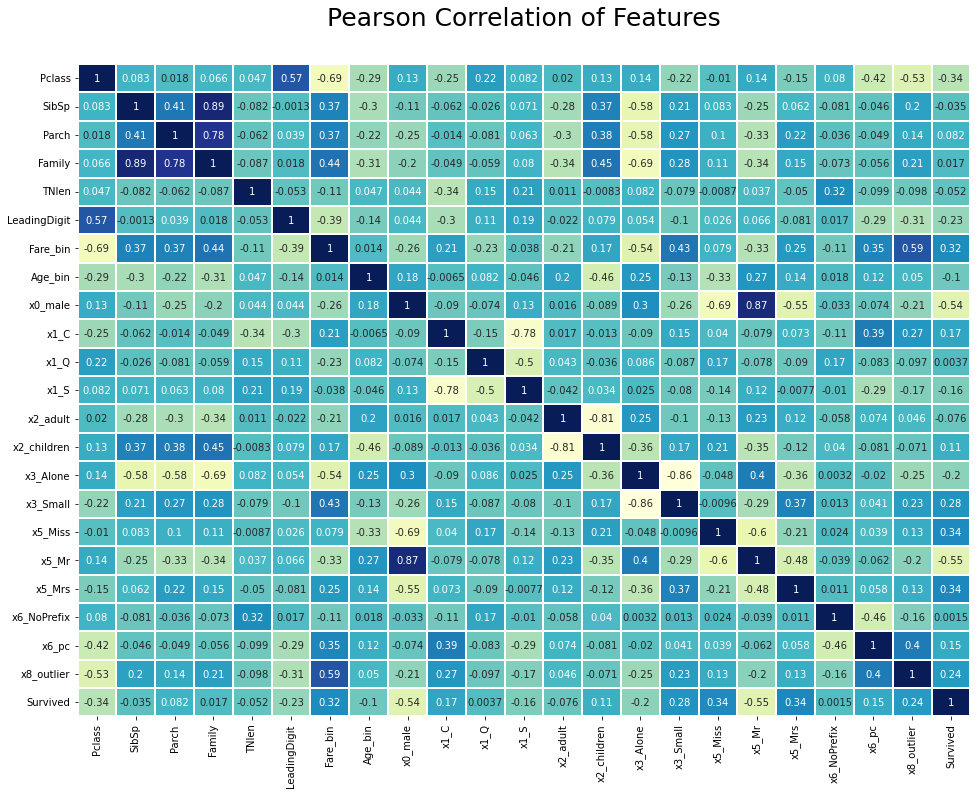

In [63]:
plt.figure(figsize=(16,12))
plt.title('Pearson Correlation of Features', y=1.05, size=25)
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=False, linecolor='white', annot=True, cmap="YlGnBu", cbar=False)
plt.show()

## Save Prepared Dataset after Feature Selection

In [65]:
# save prepared dataset as pickle file
df_train.to_pickle('df_train_prepared_reduced.pkl')
df_test.to_pickle('df_test_prepared_reduced.pkl')